## Doel:
Vul alle rijen in de kolom 'Postcode' in het excelbestand (GR18_NAs.xlsx)
Uit zelfde bestand: Als de straatnaam bekend is, dan kan de PC6 set van het CBS toegepast worden of een andere dataset.
Als de postcode NA is, dan hoeft de postcode niet ingevuld te worden.

## Plan:
1 Kijk of postcode in zoekresultaten (adres-box in google search) verschijnt.
2 Kijk of Nomatim en Open Street map de postcode kunnen vinden
3 Kijk of de postcode in de eerste n links van de zoekresultaten te vinden is

Links voor andere datasets: https://data.eindhoven.nl/explore/dataset/stembureaus-eindhoven/table/?flg=nl&disjunctive.stembureau&disjunctive.straatnaam&disjunctive.postcode
https://data.overheid.nl/dataset/6611-stembureaus (Zaanstad)
https://data.overheid.nl/dataset/stembureaus-ep (Zoetermeer)
https://data.overheid.nl/datasets?search=stembureau
Ook Amsterdam, Assen ...
GoudenGids.nl
indebuurt.nl

In [78]:
import numpy as np
import pandas as pd
import re

import requests
from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim
# https://nominatim.org/release-docs/develop/api/Output/

In [90]:
#csv = pd.read_csv('Data/GR18 stembureau.csv', sep = ",")
#print(csv.columns)
#print(csv.shape) #8614 rijen
#print(csv.head())
# Het gaat niet om de csv, maar om de excel file!

#df_NA = pd.read_excel('Data/GR18_NAs.xlsx')
df_NA = pd.read_excel('Data/GR18_minderNA.xlsx')
print(df_NA[['stembureau','postcode']].count())
#print(df_NA.head(5))

stembureau    9460
postcode      8867
dtype: int64


In [167]:
#for col in df_NA:
#    if df_NA[col].dtype == "O":
#        df_NA[col] = df_NA[col].fillna("")
#vuldit = df_NA[df_NA['postcode'] == ""] # Het bestand 'GR18_NAs.xlsx' bevat alleen de rijen met missende postcodes
#vuldit

## Gebruik van openbare datasets

In [92]:
def makekey(df,col):
    """Deze sleutel maakt het samenvoegen can kolommen op basis van een naam robuster.
    Spelfouten of andere volgordes worden echter niet als zodanig herkend."""
    df["key"] = df[col].apply(lambda s: re.sub('stembureau',' ',s.lower()))
    df["key"] = df["key"].apply(lambda s: re.sub('\W',"",s))
    df["key"] = df["key"].apply(lambda s: re.sub('\d',"",s))
    return df
    
    
def lowercolnames(df):
    df.columns = [s.lower().strip() for s in list(df.columns)]
    return df

def targetcolumns(df1,df2,object_only=False):
    if object_only:
        cols = []
        for col in df1.columns:
            if df1[col].dtype == "O" and col in list(df2.columns):
                cols.append(col)
        intersect = set(cols)
    else:
        intersect = set(df1.columns).intersection(set(df2.columns))
    print(intersect)
    return intersect

def merge_columns(df,cols, fillY=False):
    """Werkt alleen op een dataframe dat is voortgekomen uit een merge met de standaard suffixen _x en _y.
    er wordt aangenomen dan x van de data komt die moet worden aangevuld. _x"""
    for col in cols:
        X = col+"_x"
        Y = col+"_y"
        if X in df.columns and Y in df.columns:
            df[col] = [ y if type(x)!=str or x=="" else x for x,y in zip(df[X], df[Y]) ]
    
    print(df.columns)
    return df

def restore_columns(df_n,df_o):
    df = df_n[df_o.columns]
    return df

def processor(add, base, object_only=False):
    """add moet een iterable van tuples zijn met de path, het scheidingsteken van de CSVs en de kolom met de locaties"""
    print(base[['stembureau','postcode']].count())
    for df, sep, loc in add:
        print(df)
        if sep == "xlsx":
            df = pd.read_excel(df)
        else:
            df = pd.read_csv(df, sep=sep)
        df = lowercolnames(df)
        if loc not in df.columns:
            print(df.columns)
        df = makekey(df, loc)
        target = targetcolumns(df,base)
        merge = base.merge(df, how='left', left_on='key', right_on='key')
        merge = merge_columns(merge, target)
        base = restore_columns(merge, base)
        print(base[['stembureau','postcode']].count())
    return base

#vuldit['key'] = vuldit['stembureau'].apply(lambda s: re.sub('stembureau',' ',s.lower()))
#vuldit['key'] = vuldit['key'].apply(lambda s: re.sub('\W',"",s))
#vuldit['key'] = vuldit['key'].apply(lambda s: re.sub('\d',"",s))
#vuldit['key']

#print(df_test['postcode_x'].count())
#print(df_test['postcode_y'].count())
#joined = [y if type(x)!=str or x=="" else x for x,y in zip(df_test['postcode_x'], df_test['postcode_y']) ]
#print(pd.DataFrame( {"X":df_test['postcode_x'], "Y":joined} ))

df_NA = makekey(df_NA,'stembureau')

In [85]:
df_NA.columns

Index(['Column1', 'gemeente', 'plaats', 'stembureau', 'postcode', 'PC6',
       'Postcode.1', 'totaal', 'D66_stemmen', 'D66_percentage', 'GL_stemmen',
       'GL_percentage', 'PvdA_stemmen', 'PvdA_percentage', 'PvdD_stemmen',
       'PvdD_percentage', 'SP_stemmen', 'SP_percentage', 'DENK_stemmen',
       'DENK_percentage', 'BAG.referentienummer', 'straatnaam', 'huisnummer',
       'huisnummertoevoeging', 'X', 'Y', 'longitude', 'latitude', 'key'],
      dtype='object')

In [86]:
# Set met alle gemeenten

df_GR = pd.read_csv('Data/StemLokaal/2fc13394-c2fc-4492-843c-cba07e4bf8f5.csv', sep=",")
print(df_GR.columns)
#df_GR['Postcode']
df_GR = makekey(lowercolnames(df_GR), 'naam stembureau')
target = targetcolumns(df_GR, df_NA)
print(target)
df_test = df_NA.merge(df_GR, how='left', left_on='key',right_on='key')
df_test = merge_columns(df_test, target)
df_test = restore_columns(df_test, df_NA)
print(df_test.columns)
print(df_test[['stembureau','postcode']].count())
df_test.to_excel('Data/GR18_minderNA.xlsx', sheet_name='Sheet1')

Index(['_id', 'Gemeente', 'CBS gemeentecode', 'Nummer stembureau',
       'Naam stembureau', 'Gebruikersdoel het gebouw', 'Website locatie',
       'Wijknaam', 'CBS wijknummer', 'Buurtnaam', 'CBS buurtnummer',
       'BAG referentienummer', 'Straatnaam', 'Huisnummer',
       'Huisnummertoevoeging', 'Postcode', 'Plaats', 'Extra adresaanduiding',
       'X', 'Y', 'Longitude', 'Latitude', 'Districtcode', 'Openingstijden',
       'Mindervaliden toegankelijk', 'Invalidenparkeerplaatsen', 'Akoestiek',
       'Mindervalide toilet aanwezig', 'Kieskring ID', 'Hoofdstembureau',
       'Contactgegevens', 'Beschikbaarheid', 'ID', 'UUID'],
      dtype='object')
{'gemeente', 'longitude', 'huisnummer', 'latitude', 'postcode', 'huisnummertoevoeging', 'straatnaam', 'key', 'plaats'}
{'gemeente', 'longitude', 'huisnummer', 'latitude', 'postcode', 'huisnummertoevoeging', 'straatnaam', 'key', 'plaats'}
Index(['Column1', 'gemeente_x', 'plaats_x', 'stembureau', 'postcode_x', 'PC6',
       'Postcode.1', 'tota

In [89]:
# Eindhoven

Eindhoven = pd.read_csv("Data/StemLokaal/stembureaus-eindhoven.csv",';')
Eindhoven = lowercolnames(Eindhoven)
Eindhoven = makekey(Eindhoven,'stembureau')
print(Eindhoven.count())
#Eindhoven.head()
print(df_NA[df_NA['gemeente'] == 'Eindhoven'].count()) # 81
#vuldit_E = vuldit[vuldit['gemeente'] == 'Eindhoven']
target = targetcolumns(df_NA,Eindhoven)
df_test = df_NA.merge(Eindhoven, how='left', left_on='key', right_on='key')
df_test = merge_columns(df_test,target)
print(df_test[df_test['gemeente'] == 'Eindhoven'].count())
#print(df_test[df_test['gemeente'] == 'Eindhoven'].head(30))

df_test = restore_columns(df_test,df_NA)
df_test[df_test['gemeente'] == 'Eindhoven'].head()
df_test.to_excel('Data/GR18_minderNA.xlsx', sheet_name='Sheet1')

stembureau        78
straatnaam        78
postcode          78
gemeente          78
foto              78
openingstijden    78
x                 78
y                 78
lat               78
lon               78
geopunt           78
key               78
dtype: int64
Unnamed: 0              125
Column1                 125
gemeente                125
plaats                   97
stembureau              125
postcode                 97
PC6                       2
Postcode.1                3
totaal                  125
D66_stemmen             125
D66_percentage          125
GL_stemmen              125
GL_percentage           125
PvdA_stemmen            125
PvdA_percentage         125
PvdD_stemmen              0
PvdD_percentage           0
SP_stemmen              125
SP_percentage           125
DENK_stemmen            125
DENK_percentage         125
BAG.referentienummer      1
straatnaam               97
huisnummer               97
huisnummertoevoeging      2
X                         0
Y      

In [22]:
#delft  = pd.read_csv("Data/StemLokaal/Stembureaus_in_gemeente_Delft.csv",sep=",")
#delft['stembureau'] = [s.split(",",1)[0] if len(s.split(",",1)[0]) > 3 else s for s in delft['name'] ]
#delft['stembureau'] = delft['stembureau'].apply(lambda s: re.sub('Gemeente Delft', " ", s))
#delft.head(20)
#delft.to_csv('Data/StemLokaal/Stembureaus_in_gemeente_Delft_Schoon.csv',sep=",")

In [66]:
#amersfoort = pd.read_csv('Data/StemLokaal/verkiezingsuitslagen_Amersfoort_28_03_2018.csv',sep=",")
#amersfoort_partijen = amersfoort.pivot_table(index='bagID_stemburo', columns = 'partij')
#print(amersfoort_partijen.head(10))
#amersfoort_stembureaus = amersfoort.groupby('bagID_stemburo').first().drop('aantal_stemmen',axis=1)
#print(amersfoort_stembureaus.head(10))
#amersfoort_totaal = amersfoort.groupby('bagID_stemburo').sum()['aantal_stemmen']
#amersfoort_totaal.columns=['totaal_stemmen']
#print(print(amersfoort_totaal.head(10)))
#amersfoort = amersfoort_partijen['aantal_stemmen'].join((amersfoort_stembureaus,amersfoort_totaal),how='left')
#amersfoort.to_csv('Data/StemLokaal/verkiezingsuitslagen_Amersfoort_28_03_2018_pivot.csv',sep=",")

                 aantal_stemmen                                              \
partij                   50PLUS Aan. & Een. Actief Ad Bos Collectief Al.V&D   
bagID_stemburo                                                                
0307010000380440      14.000000         NaN    8.0               NaN    NaN   
0307010000380500      18.000000         NaN    NaN               NaN    NaN   
0307010000381346       6.666667         1.0   13.0               NaN    NaN   
0307010000381743       7.000000         1.0    5.0               NaN    NaN   
0307010000389724      25.400000         0.0   15.0               2.0    0.0   
0307010000390108       0.000000         0.0    NaN               NaN    NaN   
0307010000392847      21.800000         2.0   16.0               0.0    0.0   
0307010000393097       7.500000         NaN    NaN               NaN    0.0   
0307010000396441      22.200000         1.0   12.0               1.0    0.0   
0307010000403386       9.600000         0.0    4.0  

In [103]:
data = (('Data/StemLokaal/20170209-stemlocaties-amsterdam.xlsx', "xlsx", 'omschrijving stembureau'),
       ('Data/StemLokaal/Dataset_Stembureaus_Assen_2021.csv', ',', "stembureaus"),
       ('Data/Stemlokaal/infographic-ps19-denhaag.xlsx', 'xlsx', 'stembureau'),
       ('Data/StemLokaal/Stembureaus_in_gemeente_Delft_Schoon.csv', ",", 'stembureau'),
       ('Data/StemLokaal/StembureausBreda.csv', ",", "naam"),
       ('Data/StemLokaal/stembureauZaanstad.csv', ",", "naam"),
       ('Data/StemLokaal/verkiezingenschiedam-2018gr.xlsx', "xlsx", 'stembureau'),
       ('Data/StemLokaal/verkiezingsuitslagen_Amersfoort_28_03_2018_pivot.csv',',','stemburo'))
# data uit Utrecht is niet bruikbaar te maken. De tabel staat op zijn kant én heeft extra tekst aan het begin. Er staan alleen de adressen in.
test = processor(data,df_NA)

stembureau    9460
postcode      8867
dtype: int64
Data/StemLokaal/20170209-stemlocaties-amsterdam.xlsx
{'key', 'postcode'}
Index(['Unnamed: 0', 'Unnamed: 0.1', 'Column1', 'gemeente', 'plaats',
       'stembureau', 'postcode_x', 'PC6', 'Postcode.1', 'totaal',
       'D66_stemmen', 'D66_percentage', 'GL_stemmen', 'GL_percentage',
       'PvdA_stemmen', 'PvdA_percentage', 'PvdD_stemmen', 'PvdD_percentage',
       'SP_stemmen', 'SP_percentage', 'DENK_stemmen', 'DENK_percentage',
       'BAG.referentienummer', 'straatnaam', 'huisnummer',
       'huisnummertoevoeging', 'X', 'Y', 'longitude', 'latitude', 'key',
       'stadsdeel', 'toegankelijkheid cat.', 'toegankelijkheid', 'postcode_y',
       'omschrijving stembureau', 'adres stembureau', 'x-coord', 'y-coord',
       'openingstijden', 'unnamed: 9', 'postcode'],
      dtype='object')
stembureau    9477
postcode      8894
dtype: int64
Data/StemLokaal/Dataset_Stembureaus_Assen_2021.csv
{'key', 'postcode', 'plaats'}
Index(['Unnamed: 0', 'Unna

In [104]:
df_NA.to_excel('Data/GR18_minsteNA.xlsx')

## Met zoekmachines

Voorbeeld zoeken in Google:
https://www.google.nl/search?source=hp&ei=vQDFX4iNLYqckgW-sIK4Bw&q=eindhoven+stembureau+de+doelen&oq=eindhoven+stembureau+de+Proosdijkerk&gs_lcp=CgZwc3ktYWIQAzoOCAAQ6gIQtAIQmgEQ5QI6CAgAELEDEIMBOgUILhCxAzoFCAAQsQM6AggAOgIILjoGCAAQFhAeOgUIIRCgAToECCEQFVD0mQFY6LkEYMK7BGgEcAB4A4ABtgGIAbIRkgEEMTYuOZgBAKABAaoBB2d3cy13aXqwAQY&sclient=psy-ab&ved=0ahUKEwjI37y0vKrtAhUKjqQKHT6YAHcQ4dUDCAY&uact=5
Duck Duck Go heeft ook een box voor bedrijven maar deze herkent locaties niet zo vaak als bedrijven vergeleken met Google.

In [4]:
def browser(URL):
    response = requests.get(URL)
    contents = response.content
    soup = BeautifulSoup(contents)
    return soup

google_start = "https://www.google.nl/search?source=hp&ei=vQDFX4iNLYqckgW-sIK4Bw&q="
google_end = "&gs_lcp=CgZwc3ktYWIQAzoOCAAQ6gIQtAIQmgEQ5QI6CAgAELEDEIMBOgUILhCxAzoFCAAQsQM6AggAOgIILjoGCAAQFhAeOgUIIRCgAToECCEQFVD0mQFY6LkEYMK7BGgEcAB4A4ABtgGIAbIRkgEEMTYuOZgBAKABAaoBB2d3cy13aXqwAQY&sclient=psy-ab&ved=0ahUKEwjI37y0vKrtAhUKjqQKHT6YAHcQ4dUDCAY&uact=5"
# url_end is niet noodzakelijk

def URLmaker(gemeente, locatie, zoekmachine='Google'):
    """Elk woord in de strings moet worden gescheiden met een +, niet met een spatie!"""
    if zoekmachine == 'Google':
        URL = google_start+gemeente+"+"+locatie
    return URL

def scan_text(text):
    if type(text) != str:
        text = str(text)
    # Laat Beatifulsoup de adresbox, en n eerste links ophalen
    search_ = re.search(r"\d{4} [A-Z]{2}\W", text)
    search = re.search(r"\d{4}[A-Z]{2}\W", text)
    if search_ is not None:
        postcode = search_.group(0)
    elif search is not None:
        postcode = search.group(0)
    else:
        postcode = "NA"
    return postcode

def souper(SoupObj, N, zoekmachine='Google', beta = False):
    if zoekmachine == 'Google':
        box = SoupObj.find_all('div', class_='AVsepf')
        hits = SoupObj.find_all('div', class_="ZINbbc xpd O9g5cc uUPGi")
        if beta:
            return box, hits

def scrub(string):
    locatie = re.sub('Stembureau', "", string)
    return locatie

In het bestand GR18_NAs.xlsx staan de missende waarden. Waar de kolom 'postcode.1' (of 'PC6' of 'postcode') onrbreekt, mist nog data. Voor een minderheid hiervan zijn wel coordinaten en dus ook een straatnaam bekend.

In [9]:
AV = test.find_all('div', class_='AVsepf')
print(AV,"\n")
AV2 = test2.find_all('div', class_='AVsepf')
print(AV2,"\n")

[<div class="AVsepf"><div class="BNeawe s3v9rd AP7Wnd"><span><span class="BNeawe s3v9rd AP7Wnd">Adres</span></span>: <span><span class="BNeawe tAd8D AP7Wnd">Bordeauxlaan 139, 5627 GT Eindhoven</span></span></div></div>, <div class="AVsepf u2x1Od"><div class="BNeawe s3v9rd AP7Wnd"><span><span class="BNeawe s3v9rd AP7Wnd">Telefoonnummer</span></span>: <span><span class="BNeawe tAd8D AP7Wnd">040 238 8866</span></span></div></div>] 



In [11]:
#BN = test.find_all('div', class_='BNeawe UPmit AP7Wnd')
BN = test.find_all('div', class_="ZINbbc xpd O9g5cc uUPGi")
print(len(BN), BN,"\n")
#BN[4]
tekst = souper(test, 5, 'Google', True)
#tekst

12 [<div class="ZINbbc xpd O9g5cc uUPGi"><div class="kCrYT"><div class="nGphre"></div><span><h3 class="zBAuLc"><div class="BNeawe deIvCb AP7Wnd">Gymzaal Bordeauxlaan</div></h3></span><span><div class="BNeawe tAd8D AP7Wnd"><span class="r0bn4c rQMQod tP9Zud"> <span aria-hidden="true" class="Eq0J8 oqSTJd">4,3</span> <div aria-label="Beoordeeld als 4.3 uit 5" class="Hk2yDb KsR1A" role="img"><span style="width:63px"></span></div> <span class="Eq0J8">(14)</span> </span>
Sportcomplex in Eindhoven</div></span><div class="nYT7Qb"></div></div><div class="Q0HXG"></div><div class="kCrYT"><div class="skVgpb"><a class="VGHMXd" href="https://maps.google.nl/maps?um=1&amp;ie=UTF-8&amp;fb=1&amp;gl=nl&amp;sa=X&amp;geocode=KWHmP8uo3sZHMSQ7SqZD19Ix&amp;daddr=Gymzaal+Bordeauxlaan,+Bordeauxlaan+139,+5627+GT+Eindhoven&amp;ved=2ahUKEwi37tGtuKztAhXGA2MBHZXEDDAQlDt6BAgLEAM"><div class="LpaDrb S7Jdze" style="width:24px;height:24px"></div><div class="BNeawe ji5jpf uEec3 AP7Wnd">Route</div></a><a class="VGHMXd" hre

<!DOCTYPE html>
<html lang="nl"><head><meta charset="utf-8"/><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"/><title>Eindhoven Gymzaal Bordeauxlaan - Google zoeken</title><script nonce="pYBhANjLM7ibLdVFniZwOA==">(function(){
document.documentElement.addEventListener("submit",function(b){var a;if(a=b.target){var c=a.getAttribute("data-submitfalse");a="1"==c||"q"==c&&!a.elements.q.value?!0:!1}else a=!1;a&&(b.preventDefault(),b.stopPropagation())},!0);document.documentElement.addEventListener("click",function(b){var a;a:{for(a=b.target;a&&a!=document.documentElement;a=a.parentElement)if("A"==a.tagName){a="1"==a.getAttribute("data-nohref");break a}a=!1}a&&b.preventDefault()},!0);}).call(this);(function(){
var a=window.performance;window.start=Date.now();a:{var b=window;if(a){var c=a.timing;if(c){var d=c.navigationStart,f=c.responseStart;if(f>d&&f<=window.start){window.start=f;b.wsrt=f-d;break a}}a.now&&(b.wsrt=Math.floor(a.now()))}}window.googl
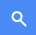
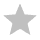
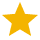
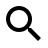
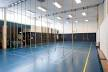
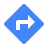
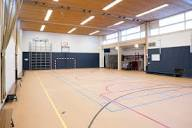

In [5]:
test = browser(URLmaker('Eindhoven','Gymzaal+Bordeauxlaan'))
test
#test2 = browser(URLmaker('Eindhoven','grand+cafe+de+zwarte+doos'))
#test2